In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [2]:
def new_path(cls, *args, **kwargs):
    cls = pathlib.WindowsPath
    self = cls._from_parts(args, init=False)
    if not self._flavour.is_supported:
        raise NotImplementedError("cannot instantiate %r on your system"
                                  % (cls.__name__,))
    self._init()
    return self

Path.__new__ = new_path

In [3]:
learn = load_learner('..')
model = learn.model.eval()

In [4]:
img = open_image('../pneumonia.jpeg')

In [5]:
pred = learn.predict(img)
cls = int(pred[1])
pred, cls

((Category PNEUMONIA, tensor(1), tensor([0.0013, 0.9987])), 1)

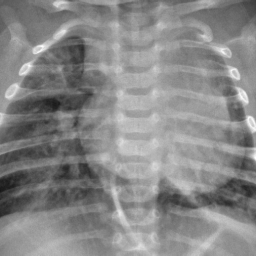

In [6]:
b, _ = learn.data.one_item(img)
img = Image(learn.data.denorm(b)[0])
b = b.cuda()
img

In [7]:
with hook_output(model[0]) as hook_a:
    with hook_output(model[0], grad=True) as hook_g:
        preds = model(b)
        preds[0, cls].backward()
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

In [8]:
grad_chan = grad.mean(1).mean(1)
mult = ((acts * grad_chan[..., None, None])).sum(0)

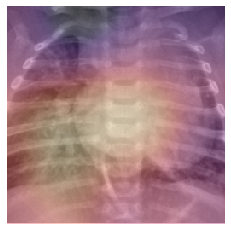

In [9]:
_,ax = plt.subplots()
img.show(ax)
ax.imshow(mult, alpha=0.4, extent=(0,256, 256,0), interpolation='bicubic', cmap='magma')